In [1]:
# Standard libraries
import os
import sys
import errno
import random
import gzip
import pickle

# Numerical and data handling
import numpy as np
import pandas as pd

# Sparse matrices and spatial operations
from scipy.sparse import csr_matrix, lil_matrix
from scipy.spatial import KDTree, ConvexHull  # KDTree for spatial queries, ConvexHull for convex hull processing
from scipy.spatial.distance import pdist, squareform
from scipy import ndimage, stats
from scipy.signal import convolve2d

# Machine learning and clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder

# Image processing and similarity metrics
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import EngFormatter

# Data visualization settings
sns.set_theme(style="whitegrid")
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

# Parallel processing
from multiprocessing import Pool
from functools import partial
import concurrent.futures

# Progress tracking
import tqdm

# Hi-C data processing
import cooler


In [24]:

sys.path.append('/share/home/mliu/shareb/mliu/HiMulti/3-sprite/CHARMtools')
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D

## 0.function

In [4]:
def flatten(nested_list):
    flattened = []
    for element in nested_list:
        if isinstance(element, list):
            flattened.extend(flatten(element))  # 递归调用flatten
        else:
            flattened.append(element)
    return flattened

def point_cloud_rotation(point_cloud, x_angle=None,y_angle=None,z_angle=None):
    if x_angle:
        rotation_matrix = np.array([[1,0,0],[0,np.cos(x_angle),-np.sin(x_angle)],[0,np.sin(x_angle),np.cos(x_angle)]])
        point_cloud = np.dot(point_cloud,rotation_matrix)
    if y_angle:
        rotation_matrix = np.array([[np.cos(y_angle),0,np.sin(y_angle)],[0,1,0],[-np.sin(y_angle),0,np.cos(y_angle)]])
        point_cloud = np.dot(point_cloud,rotation_matrix)
    if z_angle:
        rotation_matrix = np.array([[np.cos(z_angle),-np.sin(z_angle),0],[np.sin(z_angle),np.cos(z_angle),0],[0,0,1]])
        point_cloud = np.dot(point_cloud,rotation_matrix)

    return point_cloud

def plot_metrics(x,xlabel,pearson,spearman,ssmi,rms,title,color):
    # line plot of corrs ssmis and rms vs width
    fig, axes = plt.subplots(1, 4, figsize=(10, 3),dpi=120)

    axes[0].plot(x, pearson, color=color)
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel('Pearson corrs')
    axes[0].set_title('Pearson corrs')

    axes[1].plot(x, spearman, color=color)
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel('Spearman corrs')
    axes[1].set_title('Spearman corrs')

    axes[2].plot(x, ssmi, color=color)
    axes[2].set_xlabel(xlabel)
    axes[2].set_ylabel('SSIM')
    axes[2].set_title('SSIM')

    axes[3].plot(x, rms, color=color)
    axes[3].set_xlabel(xlabel)
    axes[3].set_ylabel('MSE')
    axes[3].set_title('MSE')

    plt.tight_layout()
    plt.savefig(f"{title}.png")
    
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        

def plot_matrix(matrix,title,region_start,region_end,cmap,vmax,vmin):
    plt.figure(figsize=(4,4), facecolor='white')
    plt.imshow(matrix,
               extent=(region_start, region_end, region_end, region_start),
               interpolation='none', vmin=vmin, vmax=vmax, cmap=cmap)

    plt.title(title)
    ax = plt.gca()

    ax.yaxis.set_ticks_position('left')   # 设置y轴刻度仅在左侧显示
    ax.xaxis.set_ticks_position('bottom') # 设置x轴刻度仅在底部显
    format_ticks(ax)
    #不显示grid
    ax.grid(False)
    #show colorbar
    cbar = plt.colorbar()
    cbar.set_label(title)
    cbar.set_ticks([vmin,0,vmax])
    cbar.set_ticklabels([vmin,0,vmax])
    #设置cbar大小


def plot_single_matrix(matrix,cmap="fall",title=None,vmax=1,vmin=0):
    plt.figure(figsize=(8, 3),dpi=120)
    plt.subplot(1, 2, 1)
    plt.imshow(matrix, cmap=cmap,vmax=vmax,vmin=vmin)
    plt.colorbar(label=title)
    plt.title(title)

    
# def mat_cor_with_na(mat1,mat2):
#     # Calculate distance matrices
#     distance_matrix_1 = mat1.flatten()
#     distance_matrix_2 = mat2.flatten()

#     # Replace inf values with nan
#     distance_matrix_1 = np.where(np.isinf(distance_matrix_1), np.nan, distance_matrix_1)
#     distance_matrix_2 = np.where(np.isinf(distance_matrix_2), np.nan, distance_matrix_2)

#     # Remove any NaN values from both arrays (only where both have NaNs in the same position)
#     mask = ~np.isnan(distance_matrix_1) & ~np.isnan(distance_matrix_2)

#     distance_matrix_1 = distance_matrix_1[mask]
#     distance_matrix_2 = distance_matrix_2[mask]

#     # Check if there are any remaining NaNs or infs
#     if not np.isfinite(distance_matrix_1).all() or not np.isfinite(distance_matrix_2).all():
#         raise ValueError("The input arrays contain infs or NaNs after preprocessing.")

#     # Now you can safely call pearsonr
#     pearsonr_value,_ = stats.pearsonr(distance_matrix_1, distance_matrix_2)
#     spearmanr_value,_ = stats.spearmanr(distance_matrix_1, distance_matrix_2)
#     normalized_mat1 = (mat1 - np.nanmean(mat1)) / np.nanstd(mat1)
#     normalized_mat2 = (mat2 - np.nanmean(mat2)) / np.nanstd(mat2)
#     normalized_mat1[np.isnan(normalized_mat1)] = 0
#     normalized_mat2[np.isnan(normalized_mat2)] = 0
#     ssmis = ssim(normalized_mat1, normalized_mat2)
#     mse = mean_squared_error(normalized_mat1, normalized_mat2)

#     return [pearsonr_value,spearmanr_value,ssmis,mse]
def mat_cor_with_na(mat1,mat2,sample=False):
    # Calculate distance matrices
    distance_matrix_1 = mat1.flatten()
    distance_matrix_2 = mat2.flatten()

    # Replace inf values with nan
    distance_matrix_1 = np.where(np.isinf(distance_matrix_1), np.nan, distance_matrix_1)
    distance_matrix_2 = np.where(np.isinf(distance_matrix_2), np.nan, distance_matrix_2)

    # Remove any NaN values from both arrays (only where both have NaNs in the same position)
    mask = ~np.isnan(distance_matrix_1) & ~np.isnan(distance_matrix_2)

    distance_matrix_1 = distance_matrix_1[mask]
    distance_matrix_2 = distance_matrix_2[mask]

    #sample 
    if sample:
        sample_index = np.random.choice(len(distance_matrix_1), sample, replace=False)
        distance_matrix_1 = distance_matrix_1[sample_index]
        distance_matrix_2 = distance_matrix_2[sample_index]

    # Check if there are any remaining NaNs or infs
    if not np.isfinite(distance_matrix_1).all() or not np.isfinite(distance_matrix_2).all():
        raise ValueError("The input arrays contain infs or NaNs after preprocessing.")

    # Now you can safely call pearsonr
    print(f"length is {len(distance_matrix_1)}")
    pearsonr_value,_ = stats.pearsonr(distance_matrix_1, distance_matrix_2)
    spearmanr_value,_ = stats.spearmanr(distance_matrix_1, distance_matrix_2)
    normalized_mat1 = (mat1 - np.nanmean(mat1)) / np.nanstd(mat1)
    normalized_mat2 = (mat2 - np.nanmean(mat2)) / np.nanstd(mat2)
    normalized_mat1[np.isnan(normalized_mat1)] = 0
    normalized_mat2[np.isnan(normalized_mat2)] = 0
    ssmis = ssim(normalized_mat1, normalized_mat2)
    mse = mean_squared_error(normalized_mat1, normalized_mat2)

    return [pearsonr_value,spearmanr_value,ssmis,mse]
def normalize_gam_matrix(gam_matrix, mean_slices):
    # 定义标准化后的矩阵
    normalized_matrix = np.zeros_like(gam_matrix)
    # 获取矩阵的行数和列数
    rows, cols = gam_matrix.shape
    # 遍历矩阵中的每个元素
    for i in range(rows):
        for j in range(cols):
            # 提取当前元素
            D = gam_matrix[i, j]
            # 计算 f_a 和 f_b
            f_a = mean_slices[i]
            f_b = mean_slices[j]

            # 应用标准化规则
            if D < 0:
                normalized_matrix[i, j] = min(f_a * f_b, (1 - f_a) * (1 - f_b))
            else:
                normalized_matrix[i, j] = min(f_b * (1 - f_a), f_a * (1 - f_b))

    return normalized_matrix

def generate_spheres(tdg_path, CpG_df, radius, sphere_num):
    tdg = pd.read_csv(tdg_path,sep="\t",header = None)
    tdg.columns = ["chrom","start","x","y","z"]
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000

    spheres = []
    for _ in range(sphere_num):

        # Randomly rotate the point cloud
        rotated = point_cloud_rotation(tdg[["x", "y", "z"]].values,
                                       x_angle=np.random.uniform(0, 2*np.pi),
                                       y_angle=np.random.uniform(0, 2*np.pi),
                                       z_angle=np.random.uniform(0, 2*np.pi))

        tdg_temp = tdg[["chrom", "pos"]]
        tdg_temp = tdg_temp.assign(x=rotated[:, 0], y=rotated[:, 1], z=rotated[:, 2])

        # Generate a random center point for the sphere
        x_center = np.random.uniform(tdg_temp["x"].min(), tdg_temp["x"].max())
        y_center = np.random.uniform(tdg_temp["y"].min(), tdg_temp["y"].max())
        z_center = np.random.uniform(tdg_temp["z"].min(), tdg_temp["z"].max())

        # Determine which bins are within the radius of the sphere
        tdg_temp["distance"] = np.sqrt((tdg_temp["x"] - x_center) ** 2 + 
                                       (tdg_temp["y"] - y_center) ** 2 + 
                                       (tdg_temp["z"] - z_center) ** 2)
        
        sphere = tdg_temp.query('distance <= @radius').assign(insphere=lambda x: 1)[["chrom", "pos", "insphere"]]

        # Merge with CpG_df
        sphere = pd.merge(CpG_df, sphere, how="left").fillna(0)
        spheres.append(sphere["insphere"].values)

    return spheres




def generate_spheres_size(tdg_path, radius_mean, radius_std, sphere_num, target_chr):
    tdg = pd.read_csv(tdg_path, sep="\t", header=None)
    tdg.columns = ["chrom", "start", "x", "y", "z"]
    
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000
    point_cloud = tdg[["x", "y", "z"]].values

    kd_tree = KDTree(point_cloud)
    centers = point_cloud[np.random.choice(point_cloud.shape[0], sphere_num, replace=False)]
    
    chr_point_sphere = pd.DataFrame(columns=["chrom", "start"])
    cluster_size_list = []
    
    for center in centers:
        radius = np.random.normal(radius_mean, radius_std)
        if radius <= 0:
            continue
        
        indices = kd_tree.query_ball_point(center, radius)
        hole_points = tdg.iloc[indices][["chrom", "start"]]
        cluster_size_list.append(len(hole_points))

        hole_points_chr = hole_points[hole_points["chrom"] == target_chr]
        chr_point_sphere = pd.concat([chr_point_sphere, hole_points_chr], axis=0)

    return chr_point_sphere, cluster_size_list




def process_results(results, df_bin_mm9_40kb, contact_matrix):
    matrix_size = contact_matrix.shape[0]
    #遍历所有细胞
    for result in results:
        cluster_result, cluster_size = result  

        # print(len(cluster_result)) #是切片的个数
        #遍历每个切片
        for points,size in zip(cluster_result,cluster_size):
            if points.shape[0]>0:
                print(f"size is {size}")
                weight = 2 / size
                for i in range(points.shape[0]):
                    for j in range(i+1,points.shape[0]):
                        pos1 = points[i][1]
                        pos2 = points[j][1]
                        bin1 = pos1 // 40000
                        bin2 = pos2 // 40000
                        contact_matrix[bin1, bin2] += weight
    nonzero_count = np.count_nonzero(contact_matrix)
    print(f"******************nonzero_count is {nonzero_count}")

    return contact_matrix



def scc_between_dense_matrices(matrix1: np.ndarray, matrix2: np.ndarray, h: int, dBPMax: int = -1):
    """
    计算两个输入密集矩阵之间的 Stratum-Corrected Correlation (SCC)

    Args:
        matrix1: 第一个输入矩阵 (numpy.ndarray)
        matrix2: 第二个输入矩阵 (numpy.ndarray)
        h: 平滑窗口大小
        dBPMax: 矩阵中相互作用距离的最大值 (bp)，默认值为 -1，表示不限制距离

    Returns:
        scc: 计算得到的 SCC 值
    """

    def trimDiags(a: np.ndarray, iDiagMax: int):
        """去除矩阵中对角线索引大于等于iDiagMax的元素"""
        mask = np.abs(np.arange(a.shape[0])[:, None] - np.arange(a.shape[1])) < iDiagMax
        return np.where(mask, a, 0)

    def meanFilterDense(a: np.ndarray, h: int):
        """对密集矩阵应用均值滤波"""
        fSize = 2 * h + 1
        kernel = np.ones((fSize, fSize)) / (fSize ** 2)
        ans = np.convolve(a.flatten(), kernel.flatten(), mode='same').reshape(a.shape)
        return ans

    def upperDiagDense(m: np.ndarray, nDiags: int):
        """将矩阵提取为按对角线排列的数组"""
        diags = [np.diag(m, k=i) for i in range(1, nDiags)]
        return np.array(diags)

    def varVstran(n):
        """计算稳定方差"""
        return (1 + 1.0 / n) / 12.0 if n >= 2 else np.nan

    def sccByDiag(m1: np.ndarray, m2: np.ndarray, nDiags: int):
        """按对角线计算SCC分数"""
        m1D = upperDiagDense(m1, nDiags)
        m2D = upperDiagDense(m2, nDiags)
        nSamplesD = np.array([np.count_nonzero(m1D[i] + m2D[i]) for i in range(len(m1D))])
        rowSumM1D = np.array([np.sum(m1D[i]) for i in range(len(m1D))])
        rowSumM2D = np.array([np.sum(m2D[i]) for i in range(len(m2D))])
        
        with np.errstate(divide='ignore', invalid='ignore'):
            cov = np.array([np.sum(m1D[i] * m2D[i]) for i in range(len(m1D))]) - rowSumM1D * rowSumM2D / nSamplesD
            rhoD = cov / np.sqrt(
                (np.array([np.sum(m1D[i] ** 2) for i in range(len(m1D))]) - np.square(rowSumM1D) / nSamplesD) *
                (np.array([np.sum(m2D[i] ** 2) for i in range(len(m2D))]) - np.square(rowSumM2D) / nSamplesD))
            wsD = nSamplesD * varVstran(nSamplesD)
            wsNan2Zero = np.nan_to_num(wsD, copy=True, posinf=0.0, neginf=0.0)
            rhoNan2Zero = np.nan_to_num(rhoD, copy=True, posinf=0.0, neginf=0.0)

        return rhoNan2Zero @ wsNan2Zero / wsNan2Zero.sum()

    # 去除对角线并根据最大距离dBPMax限制相互作用
    nDiags = matrix1.shape[0] if dBPMax < 0 else min(dBPMax, matrix1.shape[0])
    matrix1_trimmed = trimDiags(matrix1, nDiags)
    matrix2_trimmed = trimDiags(matrix2, nDiags)

    # 对矩阵应用均值滤波
    if h > 0:
        matrix1_filtered = meanFilterDense(matrix1_trimmed, h)
        matrix2_filtered = meanFilterDense(matrix2_trimmed, h)
    else:
        matrix1_filtered = matrix1_trimmed
        matrix2_filtered = matrix2_trimmed

    # 计算SCC
    scc = sccByDiag(matrix1_filtered, matrix2_filtered, nDiags)
    
    return scc



## bin

In [5]:
resolution = 40000
ref = "mm9"
df_mm = pd.read_csv(f"/shareb/mliu/HiMulti/ref_data/{ref}.chrom.sizes",sep="\t",header=None)
df_mm.columns = ['chrom','size']
df_mm = df_mm.query("chrom!='chrX' and chrom != 'chrY'")


bins = []

# 遍历每个染色体，生成对应的bins
for index, row in df_mm.iterrows():
    chrom = row['chrom']
    size = row['size']
    for start in range(0, size, resolution):
        stop = min(start + resolution, size)
        pos = (start + stop) // 2
        bins.append([chrom, start, stop, pos])

# 将bins列表转换为DataFrame
bin_table_df = pd.DataFrame(bins, columns=['chrom', 'start', 'stop', 'pos'])
bin_table_df_mat = bin_table_df.copy()
bin_table_df_mat['chrom'] = bin_table_df_mat['chrom'].apply(lambda x: x+"(mat)")
bin_table_df_pat = bin_table_df.copy()
bin_table_df_pat['chrom'] = bin_table_df_pat['chrom'].apply(lambda x: x+"(pat)")

df_bin_mm9_40kb = pd.concat([bin_table_df_mat,bin_table_df_pat],axis=0)
df_bin_mm9_40kb.index = range(len(df_bin_mm9_40kb))


chr_list = list(bin_table_df['chrom'].unique())

In [6]:
example_chr = "chr11"
start_pos = 109000000
end_pos = 115000000

start_idx = start_pos//40000
end_idx = end_pos//40000

hoxa_loc = f"{example_chr}:{start_pos}-{end_pos}"
start_pos_str = f"{start_pos//1000000}M"
end_pos_str = f"{end_pos//1000000}M"

print(start_pos_str,end_pos_str)

109M 115M


## SPRITE

In [7]:
#public data
sprite_data_dir = "/shareb/mliu/HiMulti/data/SPRITE"
filename = "mouse_chr11_40kb_all_nover2.txt"
sprite_data = pd.read_csv(os.path.join(sprite_data_dir,filename),sep="\t",header=None)
sprite_data = np.array(sprite_data)
sprite_data_log = np.log10(sprite_data)
print(sprite_data_log.shape)

(3047, 3047)


/tmp/ipykernel_140881/445244016.py:6: RuntimeWarning: divide by zero encountered in log10
  sprite_data_log = np.log10(sprite_data)


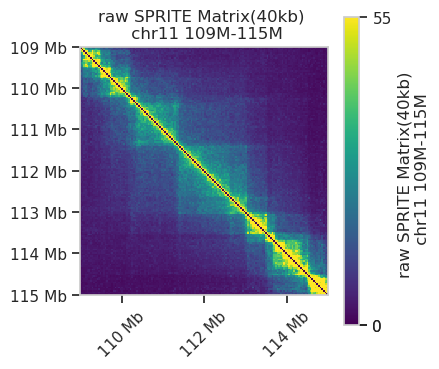

In [7]:
plot_matrix(sprite_data[start_idx:end_idx,start_idx:end_idx],f"raw SPRITE Matrix(40kb) \n chr11 {start_pos_str}-{end_pos_str}",start_pos,end_pos,"viridis",vmax=55,vmin=0)

## metadata

In [8]:
all_cells = pd.read_csv("/shareb/mliu/HiMulti/data/mESC/all_mESC_cellname.txt",sep="\t",header=None).values.flatten()
# sample_cells = np.random.choice(all_cells, 50, replace=False)

## Hi-C

In [9]:
resolution = 40000
region = "chr11(mat)"
hic_mat = np.zeros(sprite_data.shape)

for cellname in tqdm.tqdm(all_cells):
    clr=cooler.Cooler(f"/shareb/mliu/HiMulti/data/mESC/cooler/{cellname}.mm9.mcool::/resolutions/40000")
    hic_mat += clr.matrix(balance=False).fetch(region)

100%|██████████| 228/228 [00:14<00:00, 16.00it/s]


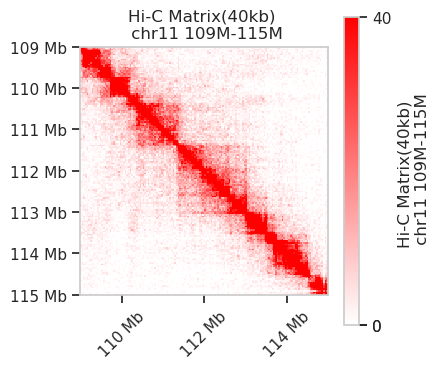

In [21]:
plot_matrix(hic_mat[start_idx:end_idx,start_idx:end_idx],f"Hi-C Matrix(40kb) \n chr11 {start_pos_str}-{end_pos_str}",start_pos,end_pos,fruitpunch,vmax=40,vmin=0)
# plot_matrix(mat_hic_40k[start_idx:end_idx,start_idx:end_idx],cmap=fruitpunch,title="Hi-C Matrix(100kb) \n chr4(pat) 80-90M",start_pos,end_pos,vmax=14,vmin=0)
# plot_single_matrix(mat_hic_log[start_idx:end_idx,start_idx:end_idx],cmap=fruitpunch,title="Hi-C Matrix(100kb) \n chr10(pat) 80M-90M",vmax=0.1,vmin=0)

In [ ]:
pearsonr_value,spearmanr_value,ssmis,mse = mat_cor_with_na(hic_mat,sprite_data) 
print(f"pearsonr_value is {pearsonr_value}\nspearmanr_value is {spearmanr_value}\nssmis is {ssmis}\nmse is {mse}")

In [ ]:
pearsonr_value,spearmanr_value,ssmis,mse = mat_cor_with_na(hic_mat[start_idx:end_idx,start_idx:end_idx],sprite_data[start_idx:end_idx,start_idx:end_idx]) 
print(f"pearsonr_value is {pearsonr_value}\nspearmanr_value is {spearmanr_value}\nssmis is {ssmis}\nmse is {mse}")

In [ ]:
h = 5  # 平滑窗口大小
dBPMax = 50  # 最大距离
scc = scc_between_dense_matrices(hic_mat[start_idx:end_idx,start_idx:end_idx],sprite_data[start_idx:end_idx,start_idx:end_idx], h, dBPMax)
print(f"SCC值: {scc}")

## 3dg Matrix

In [10]:
chrom_legnth_path_mm9 = "/shareb/mliu/HiMulti/ref_data/dip.len.mm9"
tdg_mm9_40kb_dir = "/shareb/mliu/HiMulti/data/mESC/tdg"
tdg_paths_40k2_mm9 = [f"{tdg_mm9_40kb_dir}/{cell}.40kb.3dg" for cell in all_cells]
print(len(tdg_paths_40k2_mm9))


228


## 参数 数量+半径

平均半径是25左右

In [ ]:

def generate_spheres_size(tdg_path, radius_mean, radius_std, sphere_num, target_chr):
    tdg = pd.read_csv(tdg_path, sep="\t", header=None)
    tdg.columns = ["chrom", "start", "x", "y", "z"]
    
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000
    point_cloud = tdg[["x", "y", "z"]].values

    kd_tree = KDTree(point_cloud)
    centers = point_cloud[np.random.choice(point_cloud.shape[0], sphere_num, replace=False)]
    
    chr_point_sphere = []
    cluster_size_list = []
    
    for center in centers:
        radius = np.random.normal(radius_mean, radius_std)
        if radius <= 0:
            continue
        
        indices = kd_tree.query_ball_point(center, radius)
        hole_points = tdg.iloc[indices][["chrom", "start"]]
        cluster_size_list.append(len(hole_points))

        hole_points_chr = hole_points[hole_points["chrom"] == target_chr]
        chr_point_sphere.append(hole_points_chr['start'].tolist())
    
    return chr_point_sphere, cluster_size_list

def process_tdg_path(tdg_path, df_bin, R1, R2, R3, R4, R5, number1, number2, number3, number4, number5, target_chr):
    # 生成球体数据
    cluster_result1, cluster_size1 = generate_spheres_size(tdg_path, R1, R1/10, number1, target_chr)
    cluster_result2, cluster_size2 = generate_spheres_size(tdg_path, R2, R2/10, number2, target_chr)
    cluster_result3, cluster_size3 = generate_spheres_size(tdg_path, R3, R3/10, number3, target_chr)
    cluster_result4, cluster_size4 = generate_spheres_size(tdg_path, R4, R4/20, number4, target_chr)
    cluster_result5, cluster_size5 = generate_spheres_size(tdg_path, R5, R5/20, number5, target_chr)

    cluster_result = cluster_result1 + cluster_result2 + cluster_result3 + cluster_result4 + cluster_result5
    cluster_size = cluster_size1 + cluster_size2 + cluster_size3 + cluster_size4 + cluster_size5

    num_bins = len(df_bin)
    contact_matrix = np.zeros((num_bins, num_bins))
    
    for sphere_points, size in zip(cluster_result, cluster_size):
        if size == 0:
            continue
        weight = 2 / size
        
        for i in range(len(sphere_points)):
            for j in range(i + 1, len(sphere_points)):
                start_i = sphere_points[i]
                start_j = sphere_points[j]
                bin_i = start_i // 40000
                bin_j = start_j // 40000
                
                if bin_i < num_bins and bin_j < num_bins:
                    contact_matrix[bin_i, bin_j] += weight
                    contact_matrix[bin_j, bin_i] += weight
    
    return contact_matrix

def parallel_process_cells(tdg_paths, df_bin, R1, R2, R3, R4, R5, number1, number2, number3, number4, number5):
    # 初始化综合接触矩阵
    num_bins = len(df_bin)
    combined_contact_matrix = np.zeros((num_bins, num_bins))

    # 创建部分函数
    partial_func = partial(process_tdg_path, df_bin=df_bin, 
                           R1=R1, R2=R2, R3=R3, R4=R4, R5=R5, 
                           number1=number1, number2=number2, number3=number3, number4=number4, number5=number5, target_chr="chr4(mat)")
    
    # 并行执行
    with concurrent.futures.ProcessPoolExecutor(max_workers=40) as executor:
        # 所有细胞的
        results = list(executor.map(partial_func, tdg_paths))
    
    # 处理每个细胞的结果，并累加到综合矩阵中
    for contact_matrix in results:
        combined_contact_matrix += contact_matrix
    
    return combined_contact_matrix

In [ ]:
R_list = np.linspace(3,6,3)
R1_list = [1*i for i in R_list]
R2_list = [1.76*i for i in R1_list]
R3_list = [3.80*i for i in R1_list]
R4_list = [8.19*i for i in R1_list]
R5_list = [17.71*i for i in R1_list]
print(R1_list)
print(R2_list)
print(R3_list)
print(R4_list)
print(R5_list)

k_list = np.linspace(0.5,10,5)
n1_list = [int(33.8*i) for i in k_list]
n2_list = [int(34.8*i) for i in k_list]
n3_list = [int(13.2*i) for i in k_list]
n4_list = [int(8.7*i) for i in k_list]
n5_list = [int(9.5*i) for i in k_list]


n_total_list = [n1+n2+n3+n4+n5 for (n1,n2,n3,n4,n5) in zip(n1_list, n2_list,n3_list,n4_list,n5_list)]
print(n1_list)
print(n2_list)
print(n3_list)
print(n4_list)
print(n5_list)
print(n_total_list)
df_bin = df_bin_mm9_40kb

    
region = "chr4(mat)"
df_bin_mm9_40kb_chr = df_bin_mm9_40kb.query("chrom==@region")
df_bin_mm9_40kb_chr.index = range(len(df_bin_mm9_40kb_chr))

In [ ]:
silico_sprite_list = []
for i in range(len(k_list)):
    number1 = n1_list[i]
    number2 = n2_list[i]
    number3 = n3_list[i]
    number4 = n4_list[i]
    number5 = n5_list[i]
    for j in range(len(R_list)):

        R1 = R1_list[j]
        R2 = R2_list[j]
        R3 = R3_list[j]
        R4 = R4_list[j]
        R5 = R5_list[j]

        print(f"R1 is {R1},R2 is {R2},R3 is {R3},R4 is {R4},R5 is {R5}")
        print(f"number1 is {number1},number2 is {number2},number3 is {number3},number4 is {number4},number5 is {number5}")
        combined_contact_matrix = parallel_process_cells(tdg_paths_40k2_mm9, df_bin_mm9_40kb_chr, R1, R2, R3, R4, R5, number1, number2, number3, number4, number5)
        silico_sprite_list.append(combined_contact_matrix)

In [ ]:
print(i,j,n)

In [ ]:
R_list[i]

In [ ]:
print("plotting heatmaps")    
num_columns = len(R_list)
num_rows = len(k_list)
fig, ax = plt.subplots(num_rows, num_columns, figsize=(10, 10), dpi=120)

n = 0
for i in range(len(k_list)):
    for j in range(len(R_list)):
        print(i,j,n)
        silico_sprite_local = silico_sprite_list[n][start_idx:end_idx,start_idx:end_idx]
        ax[i][j].imshow(silico_sprite_local, cmap='viridis')  # 转换为密集矩阵以便绘图
        ax[i][j].set_title(f'R {np.round(k_list[i],2)} num {np.round(R_list[j],2)}')
        ax[i][j].set_xticks([])  # 不显示刻度
        ax[i][j].set_yticks([])  # 不显示刻度
        ax[i][j].axis('off')
        n = n + 1

plt.tight_layout()  # 调整子图布局以适应画布
fig.subplots_adjust(hspace=0.5)
plt.savefig("r_norm.png")
print("plotting heatmaps done")


In [ ]:
pcorrs_S = []
scorrs_S = []
ssmis_S = []
rms_S = []
r_S = []
k_S = []
n = 0
for i in range(len(R_list)):
    for j in range(len(k_list)):  
        print(f"n is {n}") 
        mat1 = silico_sprite_list[n]
        mat2 = sprite_data
        cor_list = mat_cor_with_na(mat1,mat2)  
        pcorrs_S.append(cor_list[0])
        scorrs_S.append(cor_list[1])
        ssmis_S.append(cor_list[2])
        rms_S.append(cor_list[3])     
        r_S.append(R_list[i])
        k_S.append(k_list[j])
        n = n + 1


In [ ]:
# pearsonr_value is 0.5409702617485345
# spearmanr_value is 0.3478745139381633
# ssmis is 0.2898453869245706
# mse is 0.9180594763889405

# build pd.df
slice_width_stats = pd.DataFrame({'R':r_S,'k':k_S,'pcorrs_S':pcorrs_S,'scorrs_S':scorrs_S, 'ssmis_S':ssmis_S, 'rms_S':rms_S,})
slice_width_stats.to_csv("sphere_sprite_metrics.csv",index=False)


In [ ]:
slice_width_stats

In [ ]:
plot_metrics(slice_width_stats['R'],"R list",slice_width_stats['pcorrs_S'],slice_width_stats['scorrs_S'],slice_width_stats['ssmis_S'],slice_width_stats['rms_S'],None,"green")

In [ ]:
slice_width_stats

## 聚类

In [11]:
def load_tdg(file_path):
    tdg = pd.read_csv(file_path, sep="\t", header=None)
    tdg.columns = ["chrom", "start", "x", "y", "z"]
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000  # Adjusting position
    return tdg

def assign_bins(df, bin_size=40000):
    df['bin'] = df['start'] // bin_size
    return df


def crosslink_beads(df, n_clusters, pc):
    coords = df[['x', 'y', 'z']].values
    #至少需要2个点才能成簇
    clustering = KMeans(n_clusters=n_clusters).fit(coords)
    # clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(coords)
    df['cluster'] = clustering.labels_
    # clustering = GaussianMixture(n_components=n_clusters).fit(coords)
    # labels = clustering.predict(coords)
    # df['cluster'] = labels
    df = df[df['cluster'] != -1]  # Remove noise points
    df = df[df['cluster'].map(lambda _: np.random.rand() < pc)]  # Apply crosslinking efficiency
    return df
def crosslink_beads_dbscan(df,eps):
    coords = df[['x', 'y', 'z']].values
    #最重要的是Eps
    clustering = DBSCAN(eps=eps, min_samples=3).fit(coords)
    df['cluster'] = clustering.labels_
    df = df[df['cluster'] != -1]  # Remove noise points
    return df
pc = 1
pb = 1 #成功的概率
pl = 1

In [ ]:


# chr = "chr11(mat)"

# avg_contact_matrix_list = []
# n_cluster_list = np.linspace(5,250,10,dtype=int)
# for n_cluster in n_cluster_list:
#     print(f"n_cluster {n_cluster}")
#     contact_matrix_list = []
#     df_bin_mm9_40kb_chr = df_bin_mm9_40kb.query("chrom==@chr")
#     df_bin_mm9_40kb_chr.index = range(len(df_bin_mm9_40kb_chr))
#     sc_sprite_list = []
#     for tdg_path in tqdm.tqdm(tdg_paths_40k2_mm9):
#         cellname = tdg_path.split('/')[-1]
#         df_tdg = load_tdg(tdg_path)
#         df_tdg_chr = df_tdg.query("chrom==@chr")
#         df_tdg_chr.index = range(len(df_tdg_chr))
#         df_tdg_chr = pd.merge(df_bin_mm9_40kb_chr[['chrom','pos']],df_tdg_chr,how='left').fillna(0)
#         df_tdg_chr['bin'] = df_tdg_chr.index
#         df_tdg_chr = crosslink_beads(df_tdg_chr, n_clusters=n_cluster, pc=pc)#可能会损失bin
#         df_tdg_chr = df_tdg_chr[df_tdg_chr['cluster'].map(lambda _: np.random.rand() < pb)]
#         contact_matrix = np.zeros((len(df_tdg_chr), len(df_tdg_chr)))
#         cluster_groups = df_tdg_chr.groupby('cluster')
#         for cluster_id, group in cluster_groups:
#             fragments = group['bin'].values
#             cluster_size = len(fragments)
#             weight = 2 / cluster_size
#             for i in range(cluster_size):
#                 for j in range(i + 1, cluster_size):
#                     bin_i = fragments[i]
#                     bin_j = fragments[j]
#                     contact_matrix[bin_i, bin_j] += 1*weight
#                     contact_matrix[bin_j, bin_i] += 1*weight
#         contact_matrix_list.append(contact_matrix)
#     avg_contact_matrix = np.mean(np.stack(contact_matrix_list),axis=0)
#     avg_contact_matrix_list.append(avg_contact_matrix)

In [ ]:
# num_columns = len(n_cluster_list)
# fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 2, 2), dpi=120)
# for i, (n_cluster, img_data) in enumerate(zip(n_cluster_list, avg_contact_matrix_list)):
#     matrix_region = img_data[start_idx:end_idx,start_idx:end_idx]
#     ax[i].imshow(matrix_region, cmap='viridis',vmax=0.01)  # 转换为密集矩阵以便绘图
#     ax[i].set_title(f'cluster num {n_cluster}')
#     ax[i].set_xticks([])  # 不显示刻度
#     ax[i].set_yticks([])  # 不显示刻度
#     ax[i].axis('off')
    
# plt.tight_layout()  # 调整子图布局以适应画布
# fig.subplots_adjust(hspace=0.5)

In [ ]:
# pcorrs_D = []
# scorrs_D = []
# ssmis_D = []
# rms_D = []

# for i in avg_contact_matrix_list:
#     mat1 = i
#     mat2 = sprite_data
#     print(mat1.shape,mat2.shape)
#     cor_list = mat_cor_with_na(mat1,mat2,sample=False)

#     pcorrs_D.append(cor_list[0])
#     scorrs_D.append(cor_list[1])
#     ssmis_D.append(cor_list[2])
#     rms_D.append(cor_list[3])

# slice_width_stats = pd.DataFrame({'n_cluster_list':n_cluster_list,
#                                 'pcorrs_D':pcorrs_D,'scorrs_D':scorrs_D, 'ssmis_D':ssmis_D, 'rms_D':rms_D,})


In [ ]:
# plot_metrics(slice_width_stats['n_cluster_list'],"n_cluster_list",slice_width_stats['pcorrs_D'],slice_width_stats['scorrs_D'],slice_width_stats['ssmis_D'],slice_width_stats['rms_D'],"different_num2")

In [43]:
#dbscan
chr = "chr11(mat)"

avg_contact_matrix_list = []
cluster_size_lists = []
eps_list = np.linspace(0.4,0.7,5)
for eps in eps_list:
    print(f"eps {eps}")
    contact_matrix_list = []
    df_bin_mm9_40kb_chr = df_bin_mm9_40kb.query("chrom==@chr")
    df_bin_mm9_40kb_chr.index = range(len(df_bin_mm9_40kb_chr))
    sc_sprite_list = []
    
    cluster_size_cell = []
    for tdg_path in tdg_paths_40k2_mm9:
        
        cellname = tdg_path.split('/')[-1].split('.')[0]
        df_tdg = load_tdg(tdg_path)
        df_tdg_chr = df_tdg.query("chrom==@chr")
        df_tdg_chr.index = range(len(df_tdg_chr))
        df_tdg_chr = pd.merge(df_bin_mm9_40kb_chr[['chrom','pos']],df_tdg_chr,how='left').fillna(0)
        df_tdg_chr['bin'] = df_tdg_chr.index
        
        df_tdg_chr_result = crosslink_beads_dbscan(df_tdg_chr,eps)#可能会损失bin
        df_tdg_chr = pd.merge(df_tdg_chr[['chrom','pos','start','x','y','z','bin']],df_tdg_chr_result[['bin','cluster']],on="bin",how="left")
        
        contact_matrix = np.zeros((len(df_tdg_chr), len(df_tdg_chr)))
        cluster_groups = df_tdg_chr_result.groupby('cluster')
        
        cluster_size_list = []
        for cluster_id, group in cluster_groups:
            fragments = group['bin'].values
            cluster_size = len(fragments)
            cluster_size_list.append(cluster_size)
            weight = 2 / cluster_size
            for i in range(cluster_size):
                for j in range(i + 1, cluster_size):
                    bin_i = fragments[i]
                    bin_j = fragments[j]
                    contact_matrix[bin_i, bin_j] += 1*weight
                    contact_matrix[bin_j, bin_i] += 1*weight
        contact_matrix_list.append(contact_matrix)
        cluster_size_cell.append(cluster_size_list)
    avg_contact_matrix = np.mean(np.stack(contact_matrix_list),axis=0)
    avg_contact_matrix_list.append(avg_contact_matrix)
    cluster_size_lists.append(cluster_size_cell)

eps 0.4
eps 0.475
eps 0.55
eps 0.625
eps 0.7


In [28]:
len(cluster_size_lists[0])
flattened_list = [item for sublist in cluster_size_lists[0] for item in sublist]

In [29]:
median = np.median(flattened_list)

# 计算下四分位数 (Q1) 和上四分位数 (Q3)
q1 = np.percentile(flattened_list, 25)
q3 = np.percentile(flattened_list, 75)

# 输出结果
print(f"中位数: {median}")
print(f"下四分位数 (Q1): {q1}")
print(f"上四分位数 (Q3): {q3}")

中位数: 4.0
下四分位数 (Q1): 3.0
上四分位数 (Q3): 6.0


In [30]:

group1_list = [i for i in flattened_list if i <= 3]
group2_list = [i for i in flattened_list if i > 3 and i <= 8]
group3_list = [i for i in flattened_list if i > 8 and i <= 15]
group4_list = [i for i in flattened_list if i > 15 and i <= 80]
group5_list = [i for i in flattened_list if i >80]

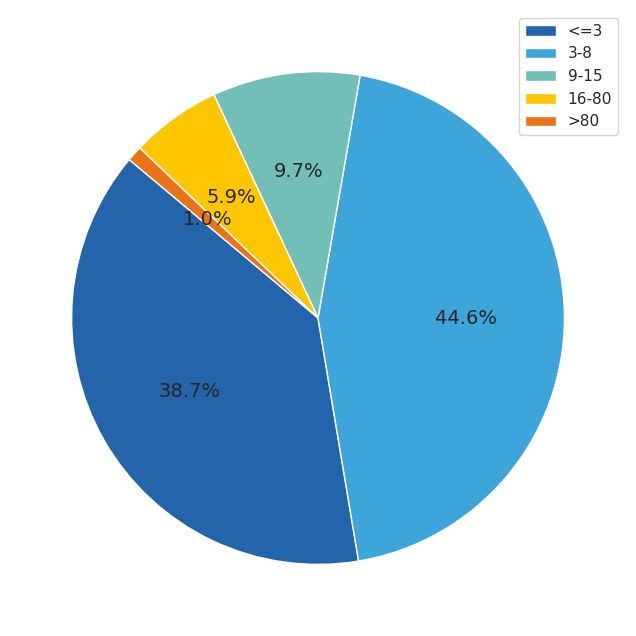

In [31]:
sizes = [len(group1_list), len(group2_list), len(group3_list), len(group4_list), len(group5_list)]
labels = ['<=3', '3-8', '9-15', '16-80', '>80']
mycolors = ["#2364aa", "#3da5d9", "#73bfb8", "#fec601",'#ea7317']
# 绘制饼图
plt.figure(figsize=(8, 8))
plt.pie(sizes, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14},colors=mycolors)

# 添加图例
plt.legend(labels, loc="best")
plt.show()

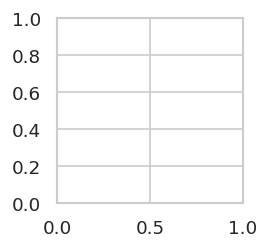

In [35]:
fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 2, 2), dpi=120)

/tmp/ipykernel_37205/2167180258.py:5: RuntimeWarning: divide by zero encountered in log
  ax[i].imshow(np.log(matrix_region), cmap='viridis')  # 转换为密集矩阵以便绘图


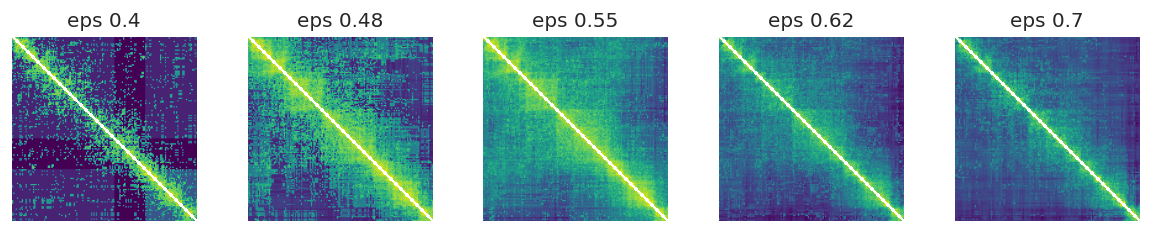

In [57]:
num_columns = len(avg_contact_matrix_list)
fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 2, 2), dpi=120)
for i, (n_cluster, img_data) in enumerate(zip(eps_list, avg_contact_matrix_list)):
    matrix_region = img_data[start_idx:end_idx,start_idx:end_idx]
    ax[i].imshow(np.log(matrix_region), cmap='viridis')  # 转换为密集矩阵以便绘图
    ax[i].set_title(f'eps {np.round(n_cluster,2)}')
    ax[i].set_xticks([])  # 不显示刻度
    ax[i].set_yticks([])  # 不显示刻度
    ax[i].axis('off')
    
plt.tight_layout()  # 调整子图布局以适应画布
fig.subplots_adjust(hspace=0.5)

In [46]:
pcorrs_D = []
scorrs_D = []
ssmis_D = []
rms_D = []

for i in avg_contact_matrix_list:
    mat1 = i[start_idx:end_idx,start_idx:end_idx]
    mat2 = sprite_data[start_idx:end_idx,start_idx:end_idx]
    print(mat1.shape,mat2.shape)
    cor_list = mat_cor_with_na(mat1,mat2,sample=False)

    pcorrs_D.append(cor_list[0])
    scorrs_D.append(cor_list[1])
    ssmis_D.append(cor_list[2])
    rms_D.append(cor_list[3])

slice_width_stats = pd.DataFrame({'eps_list':eps_list,
                                'pcorrs_D':pcorrs_D,'scorrs_D':scorrs_D, 'ssmis_D':ssmis_D, 'rms_D':rms_D,})


(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500
(150, 150) (150, 150)
length is 22500


In [47]:
slice_width_stats

,eps_list,pcorrs_D,scorrs_D,ssmis_D,rms_D
0,0.400,0.774454,0.400146,0.162869,0.451091
1,0.475,0.879500,0.722262,0.250364,0.241000
2,0.550,0.909689,0.841537,0.287945,0.180622
3,0.625,0.902511,0.847484,0.281333,0.194979
4,0.700,0.885924,0.833984,0.278701,0.228152


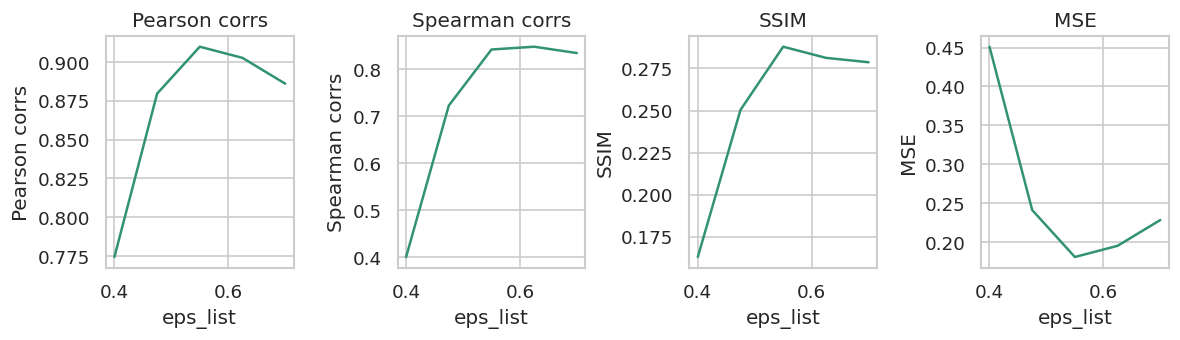

In [48]:
plot_metrics(slice_width_stats['eps_list'],"eps_list"
             ,slice_width_stats['pcorrs_D']
             ,slice_width_stats['scorrs_D']
             ,slice_width_stats['ssmis_D']
             ,slice_width_stats['rms_D'],"different_num2"
             ,"#32936f")

生成table

In [ ]:
#创建一个字典，第一个key是细胞，下一级key是cluster，保存该cluster中的bin

# n_cluster = 220
eps = 0.6
for chr in chr_list:
    chr = f"{chr}(mat)"
    print(chr)
    cluster_dict = {}
    
    df_bin_mm9_40kb_chr = df_bin_mm9_40kb.query("chrom==@chr")
    df_bin_mm9_40kb_chr.index = range(len(df_bin_mm9_40kb_chr))

    contact_matrix_list = []
    for tdg_path in tdg_paths_40k2_mm9:
        cellname = tdg_path.split('/')[-1].split('.')[0]
        df_tdg = load_tdg(tdg_path)
        df_tdg_chr = df_tdg.query("chrom==@chr")
        #每个染色体分别处理
        df_tdg_chr.index = range(len(df_tdg_chr))
        df_tdg_chr = pd.merge(df_bin_mm9_40kb_chr[['chrom','pos']],df_tdg_chr,how='left').fillna(0)
        df_tdg_chr['bin'] = df_tdg_chr.index
        
        # df_tdg_chr = crosslink_beads(df_tdg_chr, n_clusters=n_cluster, pc=pc)#可能会损失bin
        df_tdg_chr_result = crosslink_beads_dbscan(df_tdg_chr,eps)
        df_tdg_chr = df_tdg_chr[df_tdg_chr['cluster'].map(lambda _: np.random.rand() < pb)]
        
        # 将数据存储到cluster字典中
        if cellname not in cluster_dict:
            cluster_dict[cellname] = {}
        for cluster_id, group in df_tdg_chr.groupby('cluster'):
            if cluster_id not in cluster_dict[cellname]:
                cluster_dict[cellname][cluster_id] = []
            cluster_dict[cellname][cluster_id].extend(group['bin'].tolist())


        contact_matrix = np.zeros((len(df_tdg_chr), len(df_tdg_chr)))
        cluster_groups = df_tdg_chr.groupby('cluster')
        for cluster_id, group in cluster_groups:
            fragments = group['bin'].values
            cluster_size = len(fragments)
            weight = 2 / cluster_size
            for i in range(cluster_size):
                for j in range(i + 1, cluster_size):
                    bin_i = fragments[i]
                    bin_j = fragments[j]
                    contact_matrix[bin_i, bin_j] += 1*weight
                    contact_matrix[bin_j, bin_i] += 1*weight
        contact_matrix_list.append(contact_matrix)
    
    #所有细胞的平均
    avg_contact_matrix = np.mean(np.stack(contact_matrix_list),axis=0)
    # np.save(f"silico_sprite_result/mESC2_kmeans220_{chr}.npy",avg_contact_matrix)
    np.save(f"silico_sprite_result/mESC2_dbscan_{chr}.npy",avg_contact_matrix)
    #保存字典
    # with open(f"silico_sprite_result/mESC2_kmeans220_{chr}.pkl", 'wb') as file:
    with open(f"silico_sprite_result/mESC2_dbscan_{chr}.pkl", 'wb') as file:
        pickle.dump(cluster_dict, file)

    

  

charm

In [12]:
def _load_cell(cellname,resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = 40000,
        tdg_path = f"/shareb/mliu/HiMulti/data/mESC/tdg/{cellname}.40kb.3dg",
    )
    cell.add_chrom_length(chrom_length_path = "/shareb/mliu/HiMulti/ref_data/dip.len.mm9")
    cell.build_kdtree()
    return cell

with concurrent.futures.ProcessPoolExecutor(20) as executor:
   cells = list(tqdm.tqdm(executor.map(_load_cell, all_cells, 40000*np.ones(len(all_cells))), total=len(all_cells)))

esc_cells = MultiCell3D.MultiCell3D(cells)

100%|██████████| 228/228 [00:06<00:00, 35.75it/s]


In [13]:
sprite_data.shape 

(3047, 3047)

In [26]:
R_list = np.linspace(2,6,10)
# n_list = np.linspace(200,5000,10).astype(int)
mat_list = []
for R in R_list:
    mat = esc_cells.calc_insilico_GAM(genome_coord="chr11a:0-121843856",n_sphere=4000,sample_frac=0.95,radius=R)
    print(mat.shape)
    mat_list.append(mat)
    break

TypeError: calc_insilico_GAM() got an unexpected keyword argument 'n_sphere'

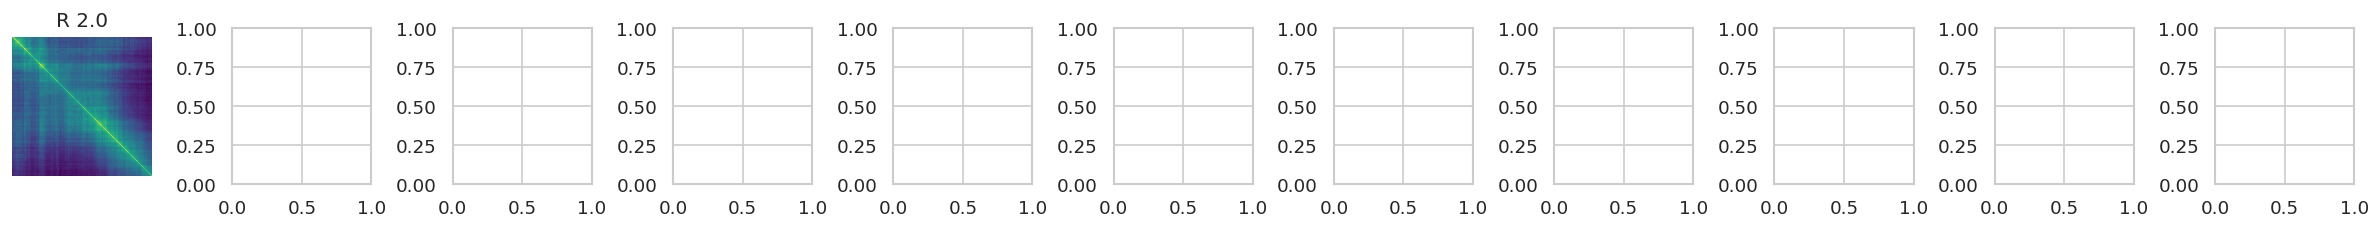

In [20]:
num_columns = len(R_list)
fig, ax = plt.subplots(1, num_columns+1, figsize=(num_columns * 2, 2), dpi=120)
for i, (r, img_data) in enumerate(zip(R_list, mat_list)):
    ax[i].imshow(img_data[start_idx:end_idx,start_idx:end_idx], cmap='viridis')  # 转换为密集矩阵以便绘图
    ax[i].set_title(f'R {np.round(r,2)}')
    ax[i].set_xticks([])  # 不显示刻度
    ax[i].set_yticks([])  # 不显示刻度
    ax[i].axis('off')

plt.tight_layout()  # 调整子图布局以适应画布
fig.subplots_adjust(hspace=0.5)


# num_columns = len(n_list)
# fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 2, 2), dpi=120)
# for i, (n, img_data) in enumerate(zip(n_list, mat_list)):
#     ax[i].imshow(img_data, cmap='viridis',vmax=0.3)  # 转换为密集矩阵以便绘图
#     ax[i].set_title(f'n {n}')
#     ax[i].set_xticks([])  # 不显示刻度
#     ax[i].set_yticks([])  # 不显示刻度
#     ax[i].axis('off')

# plt.tight_layout()  # 调整子图布局以适应画布
# fig.subplots_adjust(hspace=0.5)

In [23]:
pcorrs_D = []
scorrs_D = []
ssmis_D = []
rms_D = []

for i in mat_list:
    mat1 = i[start_idx:end_idx,start_idx:end_idx]
    mat2 = sprite_data[start_idx:end_idx,start_idx:end_idx]
    # print(mat1.shape,mat2.shape)
    cor_list = mat_cor_with_na(mat1,mat2)
    print(cor_list)
    pcorrs_D.append(cor_list[0])
    scorrs_D.append(cor_list[1])
    ssmis_D.append(cor_list[2])
    rms_D.append(cor_list[3])

slice_width_stats = pd.DataFrame({'R_list':R_list,
                                'pcorrs_D':pcorrs_D,'scorrs_D':scorrs_D, 'ssmis_D':ssmis_D, 'rms_D':rms_D,})




plot_metrics(slice_width_stats['R_list'],"R_list",slice_width_stats['pcorrs_D'],slice_width_stats['scorrs_D'],slice_width_stats['ssmis_D'],slice_width_stats['rms_D'],"different_num2","blue")






# slice_width_stats = pd.DataFrame({'n_list':n_list,
#                                 'pcorrs_D':pcorrs_D,'scorrs_D':scorrs_D, 'ssmis_D':ssmis_D, 'rms_D':rms_D,})
# plot_metrics(slice_width_stats['n_list'],"n_list",slice_width_stats['pcorrs_D'],slice_width_stats['scorrs_D'],slice_width_stats['ssmis_D'],slice_width_stats['rms_D'],"different_num2","blue")

length is 22500
[0.6918521632940291, 0.8630539321123794, 0.11942713948437067, 0.6162956734119385]


ValueError: All arrays must be of the same length

In [2]:
def matrix_diagonal_averages(matrix):
    n, m = np.shape(matrix)
    max_dist = n + m - 1
    averages = []

    for k in range(max_dist//2,-1,-1):
        diag = np.diag(matrix, k - n + 1)
        avg = np.nanmean(diag) if len(diag) > 0 else 0
        averages.append(avg)
    #averages防缩到0-1之间
    averages = np.array(averages)
    averages = (averages - np.nanmin(averages)) / (np.nanmax(averages) - np.nanmin(averages))
    return averages

In [25]:
sphere_mat = esc_cells.calc_insilico_GAM(genome_coord="chr11a:0-121843856",n_sphere=4000,sample_frac=0.95,radius=4)

100%|██████████| 4000/4000 [00:43<00:00, 92.08it/s]


In [36]:
cluster_mat= np.load(f"/shareb/mliu/HiMulti/3-sprite/silico_sprite_result/mESC2_dbscan_chr11(mat).npy")

In [40]:
#mm9的
gam_chr_40kb_path = "/shareb/mliu/HiMulti/data/multiplex_GAM/dprime_matrix/combined_segregation_at_40kb.chr11_dprime.txt.gz"
with gzip.open(gam_chr_40kb_path, 'rt') as f:
    df_gam_chr_40kb = pd.read_csv(f, header=0,index_col=0,sep='\t')  # 假设数据以制表符分隔
df_gam_chr_40kb = np.array(df_gam_chr_40kb)

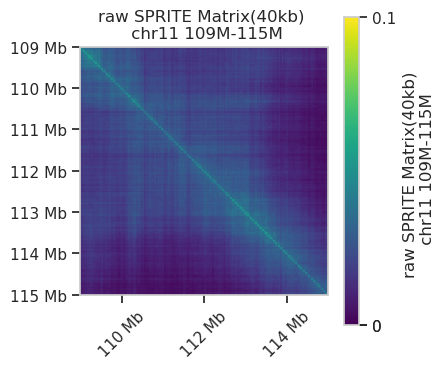

In [35]:
plot_matrix(sphere_mat[start_idx:end_idx,start_idx:end_idx],f"raw SPRITE Matrix(40kb) \n chr11 {start_pos_str}-{end_pos_str}",start_pos,end_pos,"viridis",vmax=0.1,vmin=0)

/tmp/ipykernel_140881/3387341027.py:8: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(diag) if len(diag) > 0 else 0


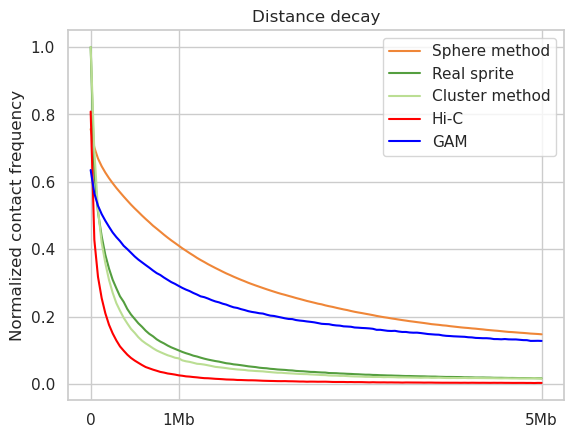

In [41]:
example_chr = "chr11"
list1 = matrix_diagonal_averages(sphere_mat)
list2 = matrix_diagonal_averages(sprite_data)
list3 = matrix_diagonal_averages(cluster_mat)
list4 = matrix_diagonal_averages(hic_mat)
list5 = matrix_diagonal_averages(df_gam_chr_40kb)

plt.plot(list1[1:125], label="Sphere method",c="#ef8638")
plt.plot(list2[1:125], label="Real sprite",c="#549e3f")
plt.plot(list3[1:125], label="Cluster method",c="#bbde93")
plt.plot(list4[1:125], label="Hi-C",c="red")
plt.plot(list5[1:125], label="GAM",c="blue")


tick_positions = [0, 24,123]  # 根据你的数据点分布调整这些值
tick_labels = ['0', '1Mb','5Mb']
plt.xticks(tick_positions, tick_labels)
plt.ylabel("Normalized contact frequency")
plt.title("Distance decay")
plt.legend()